In [1]:
#Santander Customer Transaction Prediction - GBM

#In the Kaggle competition, the objective is to identify which customer will make a transaction in the 
#future.

#Link to the competition: https://www.kaggle.com/c/santander-customer-transaction-prediction/
#Type of Problem: Classification
#Metric for evalution: AOC (Area Under Curve)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as plt

In [2]:
#Step1: Read Training Data from CSV

#Use pandas read_csv function to read the data from train.csv into a pandas dataframe.

#Then the dataframe is split into train and test datasets using sklean's train_test_split function

df_train = pd.read_csv('E:/datafiles/santander-customer-transaction-prediction/train.csv')
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [3]:
var_columns = [c for c in df_train.columns if c not in ['ID_code','target']]

X = df_train.loc[:,var_columns]
y = df_train.loc[:,'target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((160000, 200), (40000, 200), (160000,), (40000,))

In [4]:
#Step2: Create a simple GBM Model and evaluate performance

#Let us look at meaning of some of the parameters which are passed to GradientBoostingClassifier:

#1.n_estimators: 5000 will be the maximum number of trees in the model
#2.learning_rate: 0.05 will be weights assigned predictions from each tree in the model
#3.max_depth: 3 will be the maximum depth of any one tree in the model
#4.subsample: 50% of the observations would be used for fitting individual trees
#5.validation_fraction: 10% of observations would be used for validation
#6.n_iter_no_change: 20 is the stopping criteria for training.If no change is observed in performance 
#for 20 iterations, training stops
#7.max_features: log2(# features) will be considered for finding best split

model_gbm = GradientBoostingClassifier(n_estimators=5000,
                                       learning_rate=0.05,
                                       max_depth=3,
                                       subsample=0.5,
                                       validation_fraction=0.1,
                                       n_iter_no_change=20,
                                       max_features='log2',
                                       verbose=1)
model_gbm.fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6491           0.0012           50.87m
         2           0.6510           0.0008           41.46m
         3           0.6505           0.0012           37.59m
         4           0.6479           0.0014           35.57m
         5           0.6415           0.0008           34.64m
         6           0.6413           0.0013           33.62m
         7           0.6420           0.0010           32.86m
         8           0.6423           0.0008           33.11m
         9           0.6382           0.0011           32.65m
        10           0.6383           0.0009           32.55m
        20           0.6274           0.0009           33.18m
        30           0.6116           0.0010           32.24m
        40           0.6079           0.0006           33.53m
        50           0.6021           0.0006           33.03m
        60           0.5954           0.0006           32.88m
       

GradientBoostingClassifier(learning_rate=0.05, max_features='log2',
                           n_estimators=5000, n_iter_no_change=20,
                           subsample=0.5, verbose=1)

In [5]:
#Look at how many estimators/trees were finally created during training.

len(model_gbm.estimators_)

1772

In [6]:
y_train_pred = model_gbm.predict_proba(X_train)[:,1]
y_valid_pred = model_gbm.predict_proba(X_valid)[:,1]

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_valid, y_valid_pred)))

AUC Train: 0.9300
AUC Valid: 0.8934


In [7]:
#Step3: Look at performance with respect to number of trees

#staged_predict_proba function allows us to look at predictions for different number of trees in the model

y_train_pred_trees = np.stack(list(model_gbm.staged_predict_proba(X_train)))[:,:,1]
y_valid_pred_trees = np.stack(list(model_gbm.staged_predict_proba(X_valid)))[:,:,1]

y_train_pred_trees.shape, y_valid_pred_trees.shape

((1772, 160000), (1772, 40000))

In [9]:
auc_train_trees = [roc_auc_score(y_train, y_pred) for y_pred in y_train_pred_trees]
auc_valid_trees = [roc_auc_score(y_valid, y_pred) for y_pred in y_valid_pred_trees]

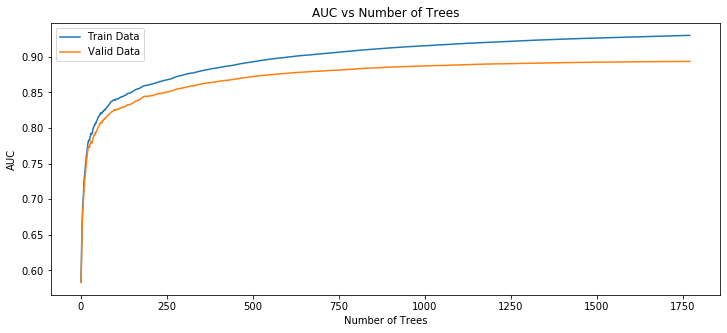

In [10]:
plt.figure(figsize=(12,5))

plt.plot(auc_train_trees, label='Train Data')
plt.plot(auc_valid_trees, label='Valid Data')

plt.title('AUC vs Number of Trees')
plt.ylabel('AUC')
plt.xlabel('Number of Trees')
plt.legend()

plt.show()

In [11]:
#Step4: Feature Importance

#Low importance features can be removed from the model for simpler, faster and more stable model


pd.DataFrame({"Variable_Name":var_columns,
              "Importance":model_gbm.feature_importances_}) \
            .sort_values('Importance', ascending=False)

,Variable_Name,Importance
81,var_81,0.028359
139,var_139,0.019560
12,var_12,0.019282
53,var_53,0.017938
26,var_26,0.016375
...,...,...
136,var_136,0.000455
47,var_47,0.000411
158,var_158,0.000309
17,var_17,0.000303


In [12]:
#Step5: Scoring for Test Data

#First, read test.csv and sample_submissions.csv

df_test = pd.read_csv('E:/datafiles/santander-customer-transaction-prediction/test.csv')
df_sample_submission = pd.read_csv('E:/datafiles/santander-customer-transaction-prediction/sample_submission.csv')

df_test.shape, df_sample_submission.shape

((200000, 201), (200000, 2))

In [18]:
X_test = df_test.loc[:,var_columns]

df_sample_submission['target'] = model_gbm.predict_proba(X_test)[:,1]
df_sample_submission

,ID_code,target
0,test_0,0.079278
1,test_1,0.273991
2,test_2,0.202982
3,test_3,0.142935
4,test_4,0.054739
...,...,...
199995,test_199995,0.056065
199996,test_199996,0.007810
199997,test_199997,0.003926
199998,test_199998,0.068467
